In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
def gen_sample(batch_size, N_agents, in_dim = None, L = None):
    """ 
        generates an inital states in [0,L1] x [0,L2] x ... x [0, Ln] of shape [Batch_size, in_dim]
    """
    #### Region with pdf > 0
    if in_dim is None and L is None:
        raise ValueError("Need either L or in dim to be set")
    if in_dim is None:
        in_dim = len(L)
    if L is None:
        L = [1. for _ in range(in_dim)]
    x = torch.rand(batch_size, N_agents, in_dim).abs()
    for i in range(len(L)):
        x[:, :, i] = torch.clamp(x[:, :, i],min = 0, max=L[i])
    return x


In [9]:
N_Agents = 1
in_dim = 2
batch_size = 256
n_samples = 2048
timesteps = 30
lam = 0.5
k_max = 12
control_energy_reg = 1e-5#1e-6 ### regularization on maximum control energy
u_max = 1 # does not do anything currently
thres = 0#1e-2 ### softness on constraint (will penalize when this much outside of rect)
dropout = 0


In [10]:
def custom_pdf(x):
    """
     Define a custom probability density function (PDF).
    """
    # = x.item()
    #return np.where(((x > 0) & (x < 1)), 1, 0)
    return np.where(((x > 0) & (x < 0.3)) | ((x > 0.6) & (x < 0.9)), 5 / 3, 0)
    #return np.where((x > 0.6) & (x < 0.9),3, 0)
max_pdf = 5 / 3

In [11]:
from densities import uniform_rect_regions as pdf
import functools
#    region  = np.array([[[0, 1.], [0, 1.]],
#                        [[0.6, 0.9], [0.7, 0.9]]])
region  = np.array([[[0, 1.], [0, 1.]]])
custom_pdf = functools.partial(pdf, regions=region)

In [12]:
import Ergodic_Loss
import Recursive_KAN
import sys
sys.path.append(r'C:\Users\JP\Documents\TU Berlin\Master\Code_RNN\Recursive_kan\Ergodic_Loss.py') 
sys.path.append(r'C:\Users\JP\Documents\TU Berlin\Master\Code_RNN\Recursive_kan\Recursive_KAN.py') 
import importlib
importlib.reload(Ergodic_Loss)
importlib.reload(Recursive_KAN)
model = Recursive_KAN.KAN_RNN_Layer(N_Agents = N_Agents, in_dim = in_dim, hidden = 32, depth = 2, n_timesteps = timesteps,sys_param_lam= lam, u_max = u_max, network_type='multi', dropout = dropout)
model.init_hidden(batch_size = batch_size)
criterion = Ergodic_Loss.Ergodicity_Loss(N_Agents = N_Agents, n_timesteps = timesteps,L = None, in_dim = in_dim, k_max = k_max, thres = thres, control_energy_reg = control_energy_reg, density = 'custom',verbose = False, pdf = custom_pdf, max_pdf = max_pdf, num_samples = 10000)


calulcated sigma: 0.05


torch.Size([256, 12, 12])
model: tensor([[[2.0716e-40, 1.4329e-34, 3.3143e-29,  ..., 6.5250e-09,
          5.6169e-10, 1.7805e-12],
         [2.5387e-32, 3.5574e-27, 1.7238e-22,  ..., 3.0014e-05,
          2.5584e-06, 8.1036e-09],
         [3.5707e-25, 1.0096e-20, 9.9752e-17,  ..., 5.1793e-03,
          4.2814e-04, 1.3527e-06],
         ...,
         [6.9913e-02, 2.8820e-02, 3.9816e-03,  ..., 9.7157e-22,
          3.1462e-26, 9.0185e-31],
         [1.7288e-01, 3.3451e-02, 2.7299e-04,  ..., 2.3049e-28,
          1.3325e-33, 3.8988e-39],
         [5.2982e-01, 1.0146e-01, 7.1249e-04,  ..., 6.3173e-36,
          7.1032e-42, 0.0000e+00]],

        [[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [1.7516e-43, 1.9128e-39, 1.3316e-36,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         ...,
         [2.0662e-03, 1.0014e-02, 3.5965e-02, 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Epoch [2000/2000], Loss: 0.052926, lr: 0.001000


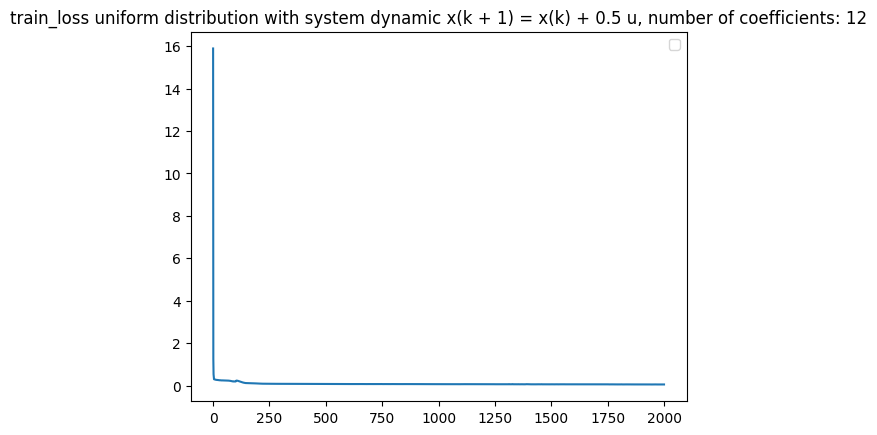

Training Complete!


In [13]:
############ Empircally we need loss < 0.01
import time
criterion.verbose = True
epochs = 2000  # Number of epochs to train
train_loss = []
test_loss = []
model.train()  # Set the model to training mode
show = True
decreased = False
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=50, eps = 1e-4)
for epoch in range(epochs):
    running_loss = 0.0 
    for samples in range(n_samples // batch_size):
        start_time = time.time()
        model.init_hidden(batch_size = batch_size)
        optimizer.zero_grad()
        outputs, control = model(gen_sample(batch_size = batch_size, N_agents = N_Agents, in_dim = in_dim))
        loss = criterion(x = outputs, u = control) + model.penalty # punishment on leaving the rect
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if show:
            show = False
            criterion.verbose = False
            print("per iter:", time.time()- start_time,"total time:" , (time.time()- start_time) * (n_samples / batch_size) * epochs)    
    avg_loss = running_loss / (n_samples // batch_size)
    ### He gets stuck here and often times not unstuck!
    #if avg_loss < 0.011 and not decreased:
    #    for param_group in optimizer.param_groups:
    #        param_group['lr'] *= 0.1
    #    decreased = True
    #if avg_loss < 0.009:
    #    break

    #scheduler.step(avg_loss) #### In our case test loss is the same as train loss
    print() 
    train_loss.append(avg_loss)
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.6f}, lr: {optimizer.param_groups[0]['lr']:6f}")
plt.plot(train_loss)
plt.title(f'train_loss uniform distribution with system dynamic x(k + 1) = x(k) + {lam} u, number of coefficients: {criterion.k_compare}')
plt.legend()
plt.show()
print("Training Complete!")

In [14]:
criterion.verbose = True
inital_state = gen_sample(batch_size = 256, N_agents = N_Agents, in_dim = in_dim)
model.init_hidden(batch_size = 256)
outs, control = model(inital_state)
criterion(x = outs, u = control)

torch.Size([256, 12, 12])
model: tensor([[[1.0989e-07, 3.5954e-05, 8.4929e-04,  ..., 5.6824e-04,
          1.8282e-05, 3.5828e-08],
         [3.9593e-05, 1.4509e-03, 1.8019e-02,  ..., 1.4363e-02,
          7.7358e-04, 1.7323e-05],
         [9.5208e-04, 1.8554e-02, 2.5829e-02,  ..., 2.2464e-02,
          1.3865e-02, 6.9513e-04],
         ...,
         [9.5365e-03, 1.9033e-02, 4.3361e-03,  ..., 4.6437e-03,
          2.3475e-02, 8.9106e-03],
         [1.3470e-03, 2.3682e-02, 1.9403e-02,  ..., 2.3076e-02,
          1.8849e-02, 9.0687e-04],
         [3.7206e-04, 8.0982e-03, 6.9139e-03,  ..., 9.2411e-03,
          7.3710e-03, 2.1656e-04]],

        [[1.0922e-07, 3.5683e-05, 8.0395e-04,  ..., 5.9456e-04,
          1.9041e-05, 3.5941e-08],
         [3.8788e-05, 1.4592e-03, 1.7985e-02,  ..., 1.4548e-02,
          7.7070e-04, 1.6692e-05],
         [9.5808e-04, 1.8459e-02, 2.6277e-02,  ..., 2.2254e-02,
          1.3688e-02, 6.7540e-04],
         ...,
         [9.6058e-03, 1.9394e-02, 4.3602e-03, 

tensor(0.0531, grad_fn=<AddBackward0>)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


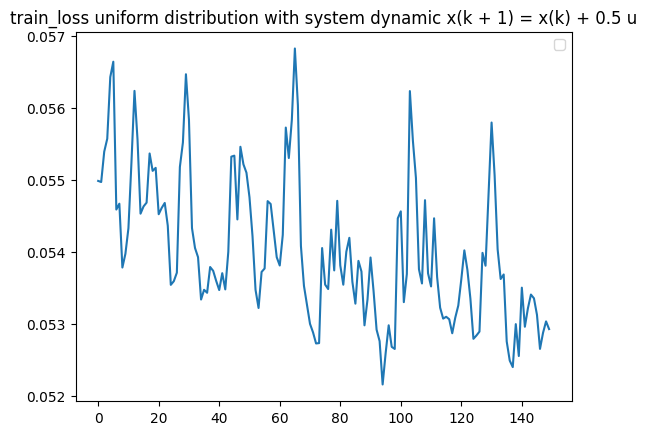

Training Complete!


In [15]:
plt.plot(train_loss[-150:])
plt.title(f'train_loss uniform distribution with system dynamic x(k + 1) = x(k) + {lam} u')
plt.legend()
plt.show()
print("Training Complete!")

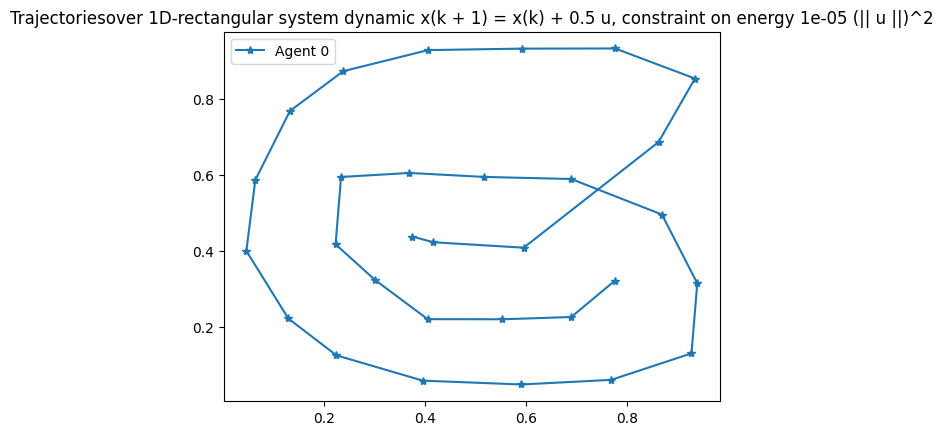

torch.Size([1, 12, 12])
model: tensor([[[1.2215e-07, 3.8908e-05, 8.6215e-04, 1.5665e-03, 1.6729e-02,
          1.2506e-02, 1.0858e-02, 9.0252e-03, 1.0047e-03, 6.1193e-04,
          1.9271e-05, 3.7863e-08],
         [4.2230e-05, 1.5365e-03, 1.8463e-02, 1.5885e-02, 1.8137e-02,
          1.4013e-02, 2.1246e-02, 1.8656e-02, 1.7543e-02, 1.4596e-02,
          7.9057e-04, 1.8182e-05],
         [1.0073e-03, 1.8929e-02, 2.6051e-02, 1.3363e-02, 1.5859e-02,
          1.9141e-02, 1.4462e-02, 1.5699e-02, 1.5482e-02, 2.2202e-02,
          1.4121e-02, 7.0308e-04],
         [1.7310e-03, 1.7874e-02, 1.2747e-02, 1.8435e-02, 3.3915e-02,
          2.1275e-02, 1.8935e-02, 2.1667e-02, 1.8312e-03, 1.4831e-02,
          2.0919e-02, 1.3696e-03],
         [1.3700e-02, 2.3559e-02, 1.9587e-02, 2.3015e-02, 3.2053e-02,
          4.7988e-02, 2.1375e-02, 2.8316e-02, 1.7475e-03, 2.8363e-03,
          2.2785e-02, 8.4283e-03],
         [8.8021e-03, 1.4905e-02, 1.9527e-02, 1.5090e-02, 1.6371e-02,
          2.9733e-02, 1.

tensor(0.0537, grad_fn=<AddBackward0>)

In [30]:
model.eval()
criterion.verbose = True
inital_state = gen_sample(batch_size = 1, N_agents = N_Agents, in_dim = in_dim)
model.init_hidden(batch_size = 1)
outs, control = model(inital_state)
for j in range(N_Agents):
    trajectory = outs[:,:,j,:].squeeze().detach()
    plt.plot(trajectory[:, 0], trajectory[:, 1], marker='*', linestyle='-', label = f'Agent {j}')
plt.title(f'Trajectoriesover 1D-rectangular system dynamic x(k + 1) = x(k) + {lam} u, constraint on energy {control_energy_reg} (|| u ||)^2')
plt.legend()
plt.show()
criterion(x = outs, u = control)



In [ ]:
import uuid
import os
random_id = str(uuid.uuid4())[:8]
filename = f'model_uniform_region_Noise_0-0.3.0.6-0.9_multiple_Agents{random_id}.pth'
path = os.path.join('models' , filename)
torch.save(model.state_dict(), path)
print(f"Model saved with filename: {filename}")

Model saved with filename: model_uniform_region_Noise_0-0.3.0.6-0.9_multiple_Agents15cbed7f.pth


In [ ]:
ev = Recursive_KAN.KAN_RNN_Layer(N_Agents = N_Agents, in_dim = in_dim, hidden = 32 , depth = 2, n_timesteps = timesteps,sys_param_lam= lam, u_max = u_max, network_type='multi', dropout = dropout)
ev.load_state_dict(torch.load(path))

<All keys matched successfully>

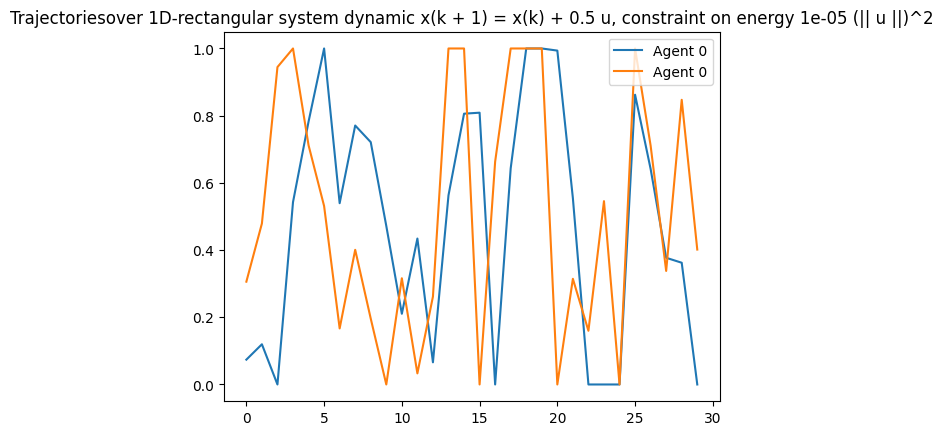

torch.Size([1, 3, 3])
model: tensor([[[0.0445, 0.0838, 0.0289],
         [0.0671, 0.0127, 0.0757],
         [0.0392, 0.0339, 0.0857]]], grad_fn=<CopySlices>) target: tensor([[0.1277, 0.1804, 0.1286],
        [0.1759, 0.2589, 0.1824],
        [0.1299, 0.1791, 0.1286]])


tensor(0.0599, grad_fn=<AddBackward0>)

In [ ]:
inital_state = gen_sample(batch_size = 1, N_agents = N_Agents, in_dim = in_dim)
ev.init_hidden(batch_size = 1)
outs, control = ev(inital_state)
for j in range(N_Agents):
    plt.plot(outs[:,:,j,:].squeeze().detach(), label = f'Agent {j}')
plt.title(f'Trajectoriesover 1D-rectangular system dynamic x(k + 1) = x(k) + {lam} u, constraint on energy {control_energy_reg} (|| u ||)^2')
plt.legend()
plt.show()
criterion(x = outs, u = control)